# Principal Component Analysis
### Part II: Demonstration using a Neural Interface

Katie Heath and Keita Yokoyama

Oct. 22, 2019 - BMME 890-014

Joint Dpt. of Biomedical Engineering, UNC-NCSU

# Study Design
* Eight volunteers (5 men, 3 women; mean age 58 ± 12 yrs.)

* "definite, probable, or probable with laboratory support ALS diagnosis (mean ALSFRS-R scores: 32 ± 8)"

* EEG
  * active Ag/AgCl electrodes
  * ref: right earlobe
  * gnd: left mastoid
  * 256 Hz acquisition + bandpass 0.1-30 Hz

## Protocol

* Prompt participantss with short words;
* Present 6 x 6 matrix of characters, and;
* Ask to focus attention on 1 character in the word at a time.

Every 250 milliseconds, a different row or column of this matrix was successively and randomly made brighter.

Two out of the 12 rows or columns (read: 1 row, and 1 column) contained the desired character.

### Protocol: Stimulus Repetition

The 12 stimulations constituted a single Stimulus Repetition...

<div>
<img src="protocol-1.png" width="800" alt="infographic contextualizing stimulus with respect to Stimulus Repetition">
</div>

### Protocol: Overall Study Design

...and 10 Stimulus Repetitions were administered for one of 35 Trials (letters).

<div>
<img src="protocol-2.png" width="800" alt="infographic for higher-order protocol structure">
</div>

# Partial Replication of *Riccio et al.*

For this analysis, we'll ignore "runs" (i.e. grouping letters together by words) for the sake of simpler analyses.

In [1]:
from scipy.io import loadmat;   import numpy as np

EEGchan=np.zeros( (8, 35, 10, 12, 64, 8) )  # initialize re-organization variables
stimTyp=np.zeros( (8, 35, 10, 12, 64, 1) )
col_row=np.zeros_like(stimTyp, dtype=np.int32)

lag=0 # manually defined lag for sample categorization

### A quick QoL detour before we continue...

In [2]:
def plotMe(x, y, xLbl, yLbl):
    plt.plot(x, y, "-", linewidth=2)
    plt.xlabel(xLbl, fontsize=16)
    plt.ylabel(yLbl, fontsize=16)

### Re-organization of EEG data + stimulus categories by protocol stage
Sort out EEG data for 8 subjects, 35 trials, 10 repetitions, and 12 stimulations.

In [3]:
for n in range(8):
    content=loadmat('../Datasets/BMI_ALS/A0'+str(n+1)+'.mat')['data'][0,0]
    trialNum=content[4][0]-1+lag 
    for trial in range(len(trialNum)):
        # one trial actually spans 9,728 samples -but only 7,680 account for 1 "trial"
        rangeNow=range(trialNum[trial], trialNum[trial]+7680)
        EEG_now=content[1][rangeNow,:]
        stimnow=content[2][rangeNow]
        clrwnow=content[3][rangeNow]
        for rep in range(10):
            rangeRep=np.arange(768)+(768*(rep)) # 768 samples = 3 seconds
            EEG_rep=EEG_now[rangeRep,:]
            stimrep=stimnow[rangeRep]
            clrwrep=clrwnow[rangeRep]
            for stm in range(12):
                rangeStm=np.arange(64)+(64*(stm)) # 64 samples = 0.25 seconds
                EEGchan[n, trial, rep, stm, ...]=EEG_rep[rangeStm,:]
                stimTyp[n, trial, rep, stm, ...]=stimrep[rangeStm]
                col_row[n, trial, rep, stm, ...]=clrwrep[rangeStm]

## Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
EEGstd=np.zeros(EEGchan.shape)
for n in range(8):
    EEGcNow=EEGchan[n,...]
    EEGcol=EEGcNow.reshape(-1,1)                  # standard scalar hates multi-D arrays
    EEGcol=StandardScaler().fit_transform(EEGcol) # standardize EEG waveform
    EEGstd[n,...]=EEGcol.reshape(EEGcNow.shape)   # return to our preferred format

## Examine Raw Data (per Channel)

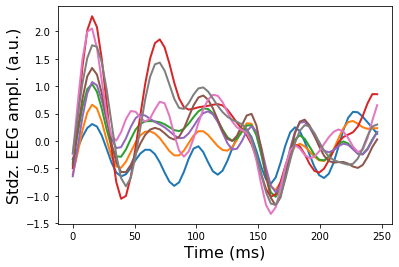

In [5]:
import matplotlib as mpl;  import matplotlib.pyplot as plt
%matplotlib inline
trial=0;  rep=0;  stim=0;  t=1000*np.arange(64)/256
for chan in range(8):
    plotMe(t, EEGstd[0,trial,rep,stim,:,chan], "Time (ms)", "Stdz. EEG ampl. (a.u.)")

## Examine Raw Data (per Subject)

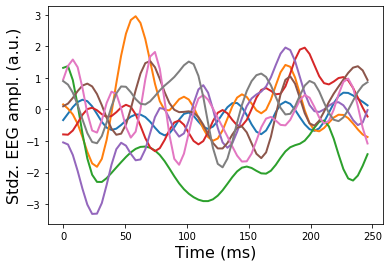

In [6]:
for subj in range(8):
    plotMe(t, EEGstd[subj,trial,rep,stim,:,0], "Time (ms)", "Stdz. EEG ampl. (a.u.)")

## Apply PCA
...except there are multiple ways to do this. Let's define some functions to make life easier...

In [7]:
def PCAprep(data_raw):
    data_red=np.zeros((8*35*10*12, 64))
    for chan in range(8):
        for trial in range(35):
            for rep in range(10):
                for stim in range(12):
                    data=data_raw[trial, rep, stim, :, chan].reshape(1,-1)
                    data_red[stim+(12*trial)+(12*10*rep)+(12*10*35*chan), :]=(
                         data)
    return data_red

In [8]:
def lblprep(data_raw):
    data_red=np.zeros((8*35*10*12, 1)).astype(np.int32)
    for chan in range(8):
        for trial in range(35):
            for rep in range(10):
                for stim in range(12):
                    X=data_raw[trial, rep, stim, :].reshape(1,-1)
                    X=X[np.nonzero(X)]
                    #if X.size == 0:
                    #    print('chan =',chan,', trial =',trial,', rep =',rep,', stim =',stim)
                    Y=np.mean(X).astype(np.int32)
                    data_red[stim+(12*trial)+(12*10*rep)+(12*10*35*chan), :]=( Y )
    return data_red

### One More Preprocessing Step
PCA only supports 2-D inputs, but we have a dataset that's both multivariate AND multi-dimensional.

Let's manually flatten our dataset so our data is 640 (all identical stimulations) x 3360 (all varying conditions).

In [9]:
from sklearn.decomposition import PCA

subj_ID=0; # one subject only!

EEG_in=PCAprep( EEGstd[subj_ID,...])
stimin=lblprep(stimTyp[subj_ID,...])
coroin=lblprep(col_row[subj_ID,...])

## Part 1: PCA with explicit number of components

The most intuitive way is to perform PCA and identify the number of components you want to keep.

In [10]:
pca1=PCA(n_components=10)

EEGpca1=pca1.fit_transform(EEG_in)

print('Original dataset dimensions:',EEG_in.shape[0],'signals,',EEG_in.shape[-1],'samples')
print('  PCA-ed dataset dimensions:',EEGpca1.shape[0],'signals,',EEGpca1.shape[-1],'values')

Original dataset dimensions: 33600 signals, 64 samples
  PCA-ed dataset dimensions: 33600 signals, 10 values


## Part 2: PCA, but try to explain 95% of variance

If you don't know the explicit number of components to keep (but you DO know the threshold to which you want your components to explain your data's variability), try:

In [11]:
pca2=PCA(0.95)
EEGpca2=pca2.fit_transform(EEG_in)

print('Original dataset dimensions:',EEG_in.shape[0],'signals,',EEG_in.shape[-1],'samples')            
print('  PCA-ed dataset dimensions:',EEGpca2.shape[0],'signals,',EEGpca2.shape[-1],'values')

Original dataset dimensions: 33600 signals, 64 samples
  PCA-ed dataset dimensions: 33600 signals, 14 values


### Explained Variance (Scree plot)
How many components should you keep?

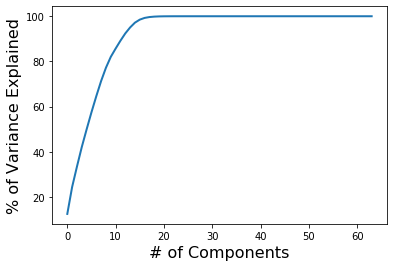

In [12]:
pcaA=PCA();  EEGpcaA=pcaA.fit_transform(EEG_in)
scree=np.cumsum( pcaA.explained_variance_ratio_ )*100
plotMe(np.arange(len(scree)), scree, "# of Components", "% of Variance Explained")

### Inverse-PCA

PCA can be inverted, which would *ideally* return your original function.

But will it, though? Or will it turn out that you lost data through PCA?

...find out by taking the mean squared distance between real/reconstructed data.

In [13]:
from sklearn.metrics import mean_squared_error
EEGinv1=pca1.inverse_transform(EEGpca1);            EEGinv2=pca2.inverse_transform(EEGpca2)
rmse1=np.sqrt(mean_squared_error(EEG_in, EEGinv1)); rmse2=np.sqrt(mean_squared_error(EEG_in, EEGinv2))
print('RMSE of 10 components:', round(rmse1,3));    print('RMSE of 95% variance: ', round(rmse2,3))

RMSE of 10 components: 0.244
RMSE of 95% variance:  0.128


## PCA in a ML Context

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import f1_score
import time
seedNum=0;     iterVal=10000;     toleVal=1e-4;     numxVal=10;     epochs=20
rafo1=RandomForestClassifier(random_state=seedNum);       rafo2=rafo1

We'll change the name of our input and ground truth variables for the Ra.Fo. classifier.

In [15]:
inRaw=EEG_in             # data in (raw)
inPCA=EEGpca2            # PCA'd version of EEG_in
truth=np.ravel(stimin)   # ground truth

Now we'll train a default-setting random forest classifier with the raw EEG dataset...

In [16]:
t0=time.time();
for epoch in range(epochs):
    rafo1.fit(inRaw, truth)

tRaw=round(time.time()-t0,1)                                   # computation time
guess1=cross_val_predict(rafo1,inRaw,truth,cv=numxVal)         # cross-validation
f1s1=round( f1_score(truth,guess1,average='weighted'), 2 )     # F1 score

/Users/keita/anaconda3/envs/bmme890/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


...and again, but with the PCA'd input (95th percentile explained).

In [17]:
t0=time.time();
for epoch in range(epochs):
    rafo2.fit(inPCA, truth)

tPCA=round(time.time()-t0,1)                                   # computation time
guess2=cross_val_predict(rafo2,inPCA,truth,cv=numxVal)         # cross-validation
f1s2=round( f1_score(truth,guess2,average='weighted'), 2 )     # F1 score

In [18]:
print('      F1 score -  Raw: ',f1s1,'  vs  PCA:',f1s2)
print(' Time to Train -  Raw: ',tRaw,'s vs  PCA:',tPCA,'s')

      F1 score -  Raw:  0.95   vs  PCA: 0.94
 Time to Train -  Raw:  20.0 s vs  PCA: 7.9 s
